## Lib

In [7]:
import tensorflow as tf
import keras
import pickle
import numpy as np
import json

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

from keras.preprocessing import image
from keras.applications.efficientnet_v2 import preprocess_input
import requests
import cv2

## Vars

In [9]:
model_path = "../../storage/models/trained/generated_model_efficientnetv2_21k_finetuned_1k_v1_trained_fine_tuned.keras"
history_path = "../../storage/models/histories/generated_model_efficientnetv2_21k_finetuned_1k_v1_trained_fine_tuned_history.pickle" 
test_dataset_path = "../../storage/datas/tf_datasets/test_dataset"

encoded_labels_json_path = "../../storage/datas/json/encoded_labels.json"

## Load Model & test Dataset

In [10]:
# Load model
model = keras.saving.load_model(model_path)

with open(history_path, 'rb') as file:
    history = pickle.load(file)

print(history.keys())


# Load datasets
test_datas = tf.data.Dataset.load(test_dataset_path)

dict_keys(['accuracy', 'loss', 'top_k_categorical_accuracy', 'val_accuracy', 'val_loss', 'val_top_k_categorical_accuracy', 'learning_rate'])


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,607,164 (74.80 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 2,031,050 (7.75 MB)

 Optimizer params: 11,717,410 (44.70 MB)

## Evaluate

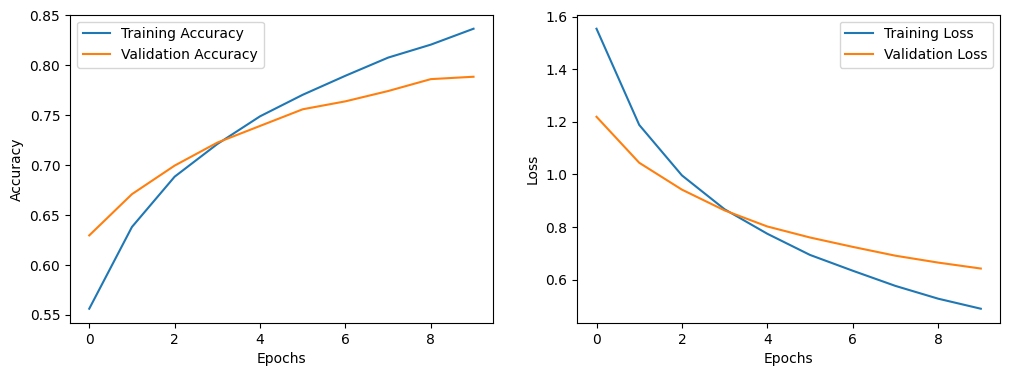

In [12]:
# Accuracy & Val_accuracy plot (training model)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training loss & Val loss plot (training model)
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [13]:
test_results = model.evaluate(test_datas)
print("Test evaluation:", test_results)
y_pred = model.predict(test_datas)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7967 - loss: 0.6955 - top_k_categorical_accuracy: 0.9303
Test evaluation: [0.6659058332443237, 0.793322741985321, 0.9459459185600281]
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [14]:
# Classification report
y_test = []
for _, label in test_datas:
    y_test.extend(np.argmax(label.numpy(), axis=-1)) 
y_test = np.array(y_test)

y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       151
           1       0.80      0.84      0.82       122
           2       0.80      0.76      0.78       115
           3       0.81      0.81      0.81       113
           4       0.77      0.86      0.81       120
           5       0.79      0.74      0.77       156
           6       0.71      0.71      0.71       122
           7       0.78      0.82      0.80       113
           8       0.71      0.62      0.66        91
           9       0.83      0.81      0.82       155

    accuracy                           0.79      1258
   macro avg       0.79      0.79      0.79      1258
weighted avg       0.79      0.79      0.79      1258



2024-04-26 14:32:40.824577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


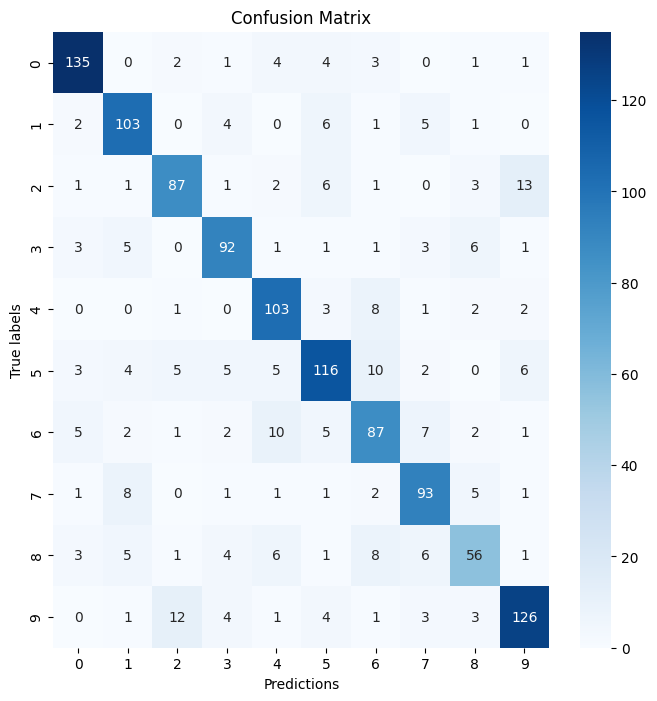

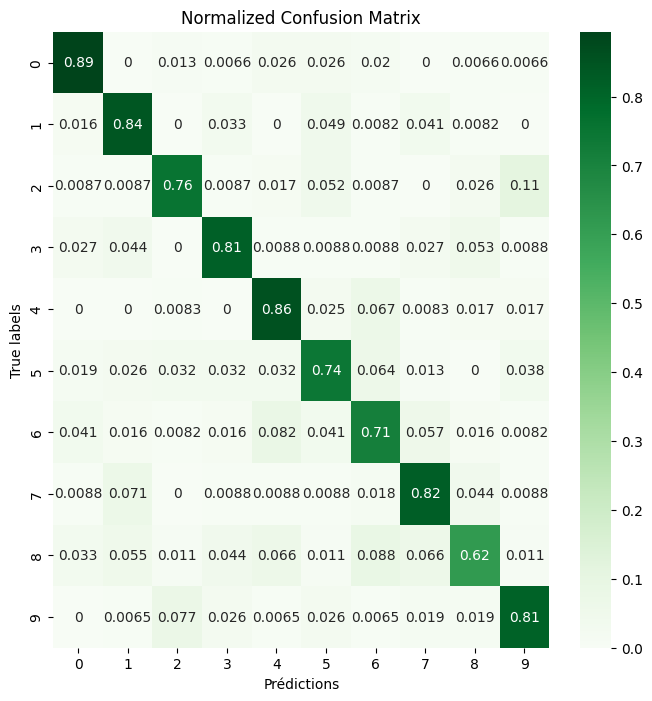

In [15]:
# Confusion Matrix

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Matrice de confusion normalisée
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized, annot=True, cmap='Greens')
plt.xlabel('Prédictions')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [17]:
# Create dictionary of encoded labels from json file
with open(encoded_labels_json_path, 'r') as file:
    encoded_labels = json.load(file)

# Reverse dictionary
encoded_labels = {v: k for k, v in encoded_labels.items()}

# Display dictionary
encoded_labels

{0: 'Boletus edulis',
 1: 'Galerina marginata',
 2: 'Ganoderma applanatum',
 3: 'Hypholoma fasciculare',
 4: 'Lepista nuda',
 5: 'Pleurotus ostreatus',
 6: 'Pluteus cervinus',
 7: 'Psilocybe cyanescens',
 8: 'Psilocybe zapotecorum',
 9: 'Trametes versicolor'}

2024-04-26 14:34:15.927245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


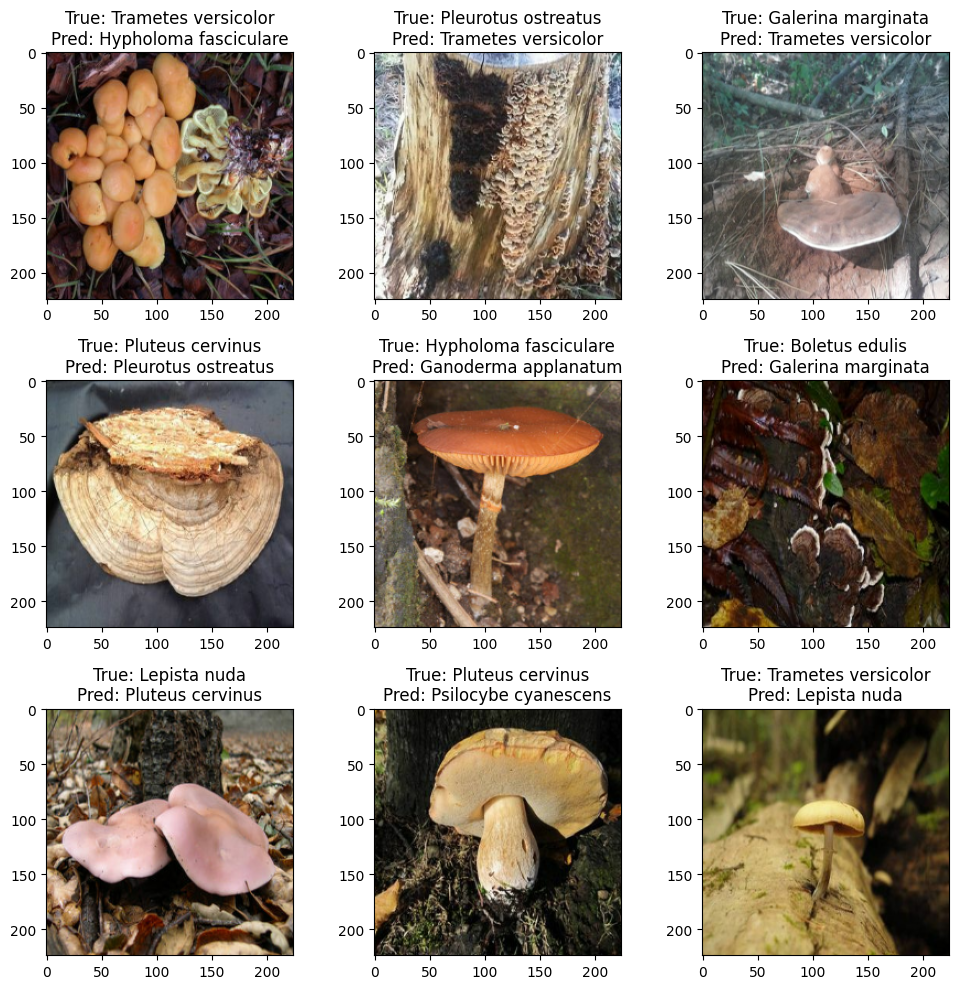

In [21]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Convert dataset to list
test_data_list = list(test_datas)

# Choose 9 randoms indexes
random_indices = random.sample(range(len(test_data_list)), 9)

# Display images & labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img, label = test_data_list[random_indices[i]]
    img = img.numpy()

    random_index = random.randint(0, len(img) - 1)
    img = img[random_index]

    true_label = encoded_labels[np.argmax(label)]
    predicted_label = encoded_labels[y_pred_classes[random_indices[i]]]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()

### Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


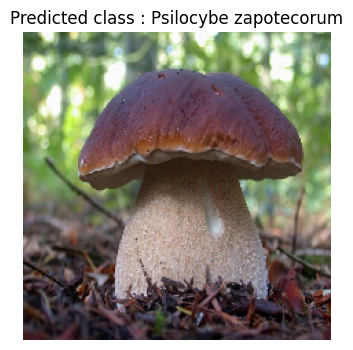

In [11]:
# IMG URL
url = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.cestaysetas.com%2Fwp-content%2Fuploads%2F2012%2F04%2F74134_160039200702311_100000886951071_284104_687032_n.jpg&f=1&nofb=1&ipt=8d65de19db5d94f6e3b4757f812aecdced3aecca20c01dc0cdb9080939a3c57f&ipo=images'


# load img, pre-process
response = requests.get(url)
if response.status_code == 200:
    image_data = response.content
    img_web = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)
    img_web = cv2.cvtColor(img_web, cv2.COLOR_BGR2RGB)
    img_web = cv2.resize(img_web, (224, 224))


    w = image.img_to_array(img_web)
    w = np.expand_dims(w, axis=0)
    w = preprocess_input(w)
    
# Predict
web_prediction = model.predict(w)
index_classe_web = np.argmax(web_prediction)
nom_classe_predite = encoded_labels[index_classe_web]

# Show img with predicted class
plt.figure(figsize=(4, 4))
plt.imshow(img_web)
plt.title(f'Predicted class : {nom_classe_predite}')
plt.axis('off')
plt.show()